In [1]:
import numpy as np
import pandas as pd
import random as r
import math
import os
from datetime import timedelta

import matplotlib.pyplot as plot
import networkx as nx
import seaborn as sns

from pyomo.environ import *
from pyomo.opt import SolverFactory
from gurobipy import GRB

In [2]:
#id directories
data_dir = os.getcwd().replace('/model', '/data')
results_dir = os.getcwd().replace('/model', '/results')


CAP_reliability = [-2,-1,0] # -1 if 1 sd below mean, -2 if 2 sd below mean
DEMAND_reliability = [0,1,2] #1 if 1 sd above mean, 2 if 2 sd above mean
budget_levels = range(1,30+1)

level_amount_incrememented = 10000
warehouse_cap_level = 3 #time intervals of supply that can be stored

trade_off_dict = {}

In [3]:
#define sets
K = 1
I = 4
T = 10

In [4]:
def initialize_model(CAP_reliability, DEMAND_reliability, 
                     budget_level):
    
    global warehouse_cap_level
    global level_amount_incrememented
    global K
    global I
    global T
    
    #define parameters

    #rank
    r_k_dict = {
        1 : 1
    }

    #quality (supplier 4 has the highest quality)
    q_k_i_dict = {
        tuple([1,1]) : 2,
        tuple([1,2]): 2,
        tuple([1,3]): 2,
        tuple([1,4]): 3
    }

    #starting inventory
    z_k_i_init_dict = {
        tuple([1,1]) : 12000/4,
        tuple([1,2]) : 12000/4,
        tuple([1,3]) : 12000/4,
        tuple([1,4]) : 12000/4
    }

    alpha_k_init_dict = {
        1 : 1000
    }

    #lead time (supplier 3 has the lowest lead time)
    f_k_i_tDiff_dict = {}

    for k in range(1,K+1):
        for i in range(1,I+1):
            for t in range(T+1):
                if (i == 3):
                    if (t == 0):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                    elif (t == 1):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                    elif (t == 2):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                    elif (t == 3):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                    else:
                        f_k_i_tDiff_dict[tuple([k,i,t])] = 0
                else:
                    if (t == 3):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                    elif (t == 4):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .3
                    elif (t == 5):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                    elif (t == 6):
                        f_k_i_tDiff_dict[tuple([k,i,t])] = .2
                    else:
                        f_k_i_tDiff_dict[tuple([k,i,t])] = 0


    o_k_i_t_dict = {}

    for k in range(1,K+1):
        for i in range(1,I+1):
            for t in range(1,T+1):
                if t < 3:
                    o_k_i_t_dict[tuple([k,i,t])] = 1000
                else:
                    o_k_i_t_dict[tuple([k,i,t])] = 0

    #size
    s_k_dict = {
        1 : .5
    }

    #warehouse capacity
    h = 11918*.5*warehouse_cap_level #assuming warehouse capacity is not an issue

    #cost (supplier 2 has the lowest cost)
    c_k_i_dict = {
        tuple([1,1]) : 1,
        tuple([1,2]) : .8,
        tuple([1,3]) : 1,
        tuple([1,4]) : 1
    }

    b = 12000*budget_level

    #lead time (supplier 1 has the higest capacity)
    CAP_k_i_t_dict_mu_sd = {}

    for k in range(1,K+1):
        for i in range(1,I+1):
            for t in range(T+1):
                if (i == 1):
                    CAP_k_i_t_dict_mu_sd[tuple([k,i,t])] = [30000, 30000*.1]
                else:
                    CAP_k_i_t_dict_mu_sd[tuple([k,i,t])] = [10000, 10000*.1]

    D_k_t_dict_mu_sd = {
        tuple([1,1]) : [12000, 1200],
        tuple([1,2]) : [12000, 1200],
        tuple([1,3]) : [12000, 1200],
        tuple([1,4]) : [12000, 1200],
        tuple([1,5]) : [12000, 1200],
        tuple([1,6]) : [12000, 1200],
        tuple([1,7]) : [12000, 1200],
        tuple([1,8]) : [12000, 1200],
        tuple([1,9]) : [12000, 1200],
        tuple([1,10]) : [12000, 1200]
    }
    
    model = ConcreteModel()

    #####define sets#######
    model.K = Set(initialize = range(1,K+1))
    model.I = Set(initialize = range(1,I+1))
    model.T = Set(initialize = range(1,T+1))

    ####initialize parameters####

    def rank_param_initialize(model, k):
        return(r_k_dict.get(k))

    model.r_k = Param(model.K, initialize = rank_param_initialize)

    #model.r_k.pprint()

    def penalty_param_initialize(model, k):
        return(1/model.r_k[k])

    model.p_k = Param(model.K, initialize = penalty_param_initialize)

    #model.p_k.pprint()

    def discount_param_initialize(model, k, t):
        discount_temp = model.p_k[k]
        #time_diff = T-t
        return(1/((1+discount_temp)**(t-1)))

    model.tau_k_t = Param(model.K, model.T, initialize = discount_param_initialize)

    #model.tau_k_t.pprint()

    def quality_param_initialize(model, k, i):
        return(q_k_i_dict.get(tuple([k,i])))

    model.q_k_i = Param(model.K, model.I, initialize = quality_param_initialize)

    #model.q_k_i.pprint()

    def beg_inv_param_initialize(model, k, i):
        return(z_k_i_init_dict.get(tuple([k,i])))

    model.z_k_i_init = Param(model.K, model.I, initialize = beg_inv_param_initialize)

    #model.z_k_i_init.pprint()

    def unfulfilled_demand_param_initialize(model, k):
        return(alpha_k_init_dict.get(k))

    model.alpha_k_intialize = Param(model.K, initialize = unfulfilled_demand_param_initialize)

    #model.alpha_k_intialize.pprint()

    def delay_dist_param_initialize(model, k, i, t):
        return(f_k_i_tDiff_dict.get(tuple([k,i,t])))

    model.f_k_i_tDiff = Param(model.K, model.I, model.T, initialize = delay_dist_param_initialize)

    #model.f_k_i_tDiff.pprint()

    def incoming_orders_initialize(model, k, i, t):
        return(o_k_i_t_dict.get(tuple([k,i,t])))

    model.o_k_i_t = Param(model.K, model.I, model.T, initialize = incoming_orders_initialize)

    #model.o_k_i_t.pprint()

    def item_size_param_initialize(model, k):
        return(s_k_dict.get(k))

    model.s_k = Param(model.K, initialize = item_size_param_initialize)

    #model.s_k.pprint()

    def warehouse_cap_param_initialize(model):
        return(h)

    model.h = Param(initialize = h)

    #model.h.pprint()

    def cost_param_initialize(model, k, i):
        return(c_k_i_dict.get(tuple([k,i])))

    model.c_k_i = Param(model.K, model.I, initialize = cost_param_initialize)

    #model.c_k_i.pprint()

    def budget_param_initialize(model):
        return(b)

    model.b = Param(initialize = budget_param_initialize)

    #model.b.pprint()

    def supplier_cap_param_initialize(model, k, i, t):
        temp = CAP_k_i_t_dict_mu_sd.get(tuple([k,i,t]))
        mean = temp[0]
        sd = CAP_reliability*temp[1]
        return(mean+sd)

    model.cap_k_i_t = Param(model.K, model.I, model.T, initialize = supplier_cap_param_initialize)

    #model.cap_k_i_t.pprint()

    #assume preparing for one sd above the mean
    def mu_plus_sigma_demand_param_initialize(model, k, t):
        temp = D_k_t_dict_mu_sd.get(tuple([k,t]))
        mean = temp[0]
        sd = DEMAND_reliability*temp[1]
        return(mean+sd)

    model.d_k_t = Param(model.K, model.T, initialize = mu_plus_sigma_demand_param_initialize)

    #model.d_k_t.pprint()

    ####initialize variables####
    model.x_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount ordered
    model.y_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals) #amount recieved
    model.z_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)
    model.alpha_k_t = Var(model.K, model.T, within = NonNegativeReals)
    model.beta_k_i_t = Var(model.K, model.I, model.T, within = NonNegativeReals)
    
    return(model)

In [5]:
def initialize_objective(model):
    model.Objective = Objective(expr = 
                                (sum(model.q_k_i[k,i]*sum(model.tau_k_t[k,t]*model.beta_k_i_t[k,i,t] 
                                                          for t in model.T) 
                                     for i in model.I for k in model.K)),
                                sense = maximize)
    return(model)

In [6]:
def initialize_constraints(model):
    def beggining_inventory_constraint_initialize(model, k, i):
        return(model.z_k_i_t[k,i,1] == model.z_k_i_init[k,i])

    model.beggining_inventory_constraint = Constraint(model.K, model.I, rule = beggining_inventory_constraint_initialize)
    
    def initalize_unsatisfied_demand_constraint_initialize(model, k):
        return(model.alpha_k_t[k,1] == model.alpha_k_intialize[k])

    model.initalize_unsatisfied_demand_constraint_initialize = \
    Constraint(model.K, rule = initalize_unsatisfied_demand_constraint_initialize)
    
    def incoming_orders_constraint_initialize(model, k, i, t):
        return(model.y_k_i_t[k,i,t] - 
               sum(model.f_k_i_tDiff[k, i, t-t_ordered_time]*model.x_k_i_t[k,i,t_ordered_time] 
                   for t_ordered_time in range(1,t)) - model.o_k_i_t[k,i,t] == 0)

    model.incoming_ordered_constraint = Constraint(model.K, model.I, model.T, 
                                                   rule = incoming_orders_constraint_initialize)
    
    def calculate_available_inventory_constraint_initialize(model, k, i, t):
        if (t > 1):
            return(model.z_k_i_t[k,i,t] - model.z_k_i_t[k,i,t-1] - model.y_k_i_t[k,i,t-1] + model.beta_k_i_t[k,i,t-1] == 0)
        else:
            return(Constraint.Skip)

    model.calculate_available_inventory_constraint = Constraint(model.K, model.I, model.T,
                                                                rule = 
                                                                calculate_available_inventory_constraint_initialize)
    
    def cannot_fulfill_more_than_available_constraint_initialize(model, k,i,t):
        return(model.beta_k_i_t[k,i,t] - model.z_k_i_t[k,i,t] <= 0)

    model.cannot_fulfill_more_than_available_constraint = \
    Constraint(model.K, model.I, model.T, rule = cannot_fulfill_more_than_available_constraint_initialize)
    
    def calculate_unsatisfied_demand_constraint_initialize(model,k,t):
        if t > 1:
            return(model.alpha_k_t[k,t] - model.alpha_k_t[k,t-1] + sum(model.beta_k_i_t[k,i,t] for i in model.I) == \
                   model.d_k_t[k,t])
        else:
            return(Constraint.Skip)

    model.calculate_unsatisfied_demand_constraint = \
    Constraint(model.K, model.T, rule = calculate_unsatisfied_demand_constraint_initialize)
    
    def warehouse_capacity_constraint_initialize(model, t):
        return(sum(model.s_k[k]*model.z_k_i_t[k,i,t] for k in model.K for i in model.I) <= model.h)

    model.warehouse_capacity_constraint = \
    Constraint(model.T, rule = warehouse_capacity_constraint_initialize)
    
    def budget_constraint_initialize(model):
        return(sum(model.c_k_i[k,i]*model.x_k_i_t[k,i,t] 
                   for k in model.K for i in model.I for t in model.T) 
               <= model.b)

    model.budget_constraint = \
    Constraint(rule = budget_constraint_initialize)
    
    def supplier_constraint_initialize(model, k, i, t):
        return(model.x_k_i_t[k,i,t] <= model.cap_k_i_t[k,i,t])

    model.supplier_constraint = \
    Constraint(model.K, model.I, model.T, rule = supplier_constraint_initialize)
    
    return(model)

In [7]:
for c in CAP_reliability:
    for d in DEMAND_reliability:
        objective_itr = [0,1]
        b = 1
        while(objective_itr[b-1] < objective_itr[b]):    
            model = initialize_model(c, d, b)
            model = initialize_objective(model)
            model = initialize_constraints(model)
            opt = pyomo.opt.SolverFactory("glpk")
            results = opt.solve(model)
            opt.solve(model)
            trade_off_dict[tuple([c,d,b*10000])] = value(model.Objective) #model.Objective.value()
            objective_itr.append(value(model.Objective))#model.Objective.value())
            b = b + 1

In [8]:
with open('test.csv', 'w') as f:
    for key in trade_off_dict.keys():
        f.write("%s,%s\n"%(key,trade_off_dict[key]))

In [9]:
budget = []
supplier_reliability = []
demand_reliability = []
obj_value = []

for k in trade_off_dict.keys():
    obj_value.append(trade_off_dict.get(k))
    budget.append(k[2])
    if (k[0] == -2):
        supplier_reliability.append('2 high')
    elif (k[0] == -1):
        supplier_reliability.append('1 medium')
    else:
        supplier_reliability.append('0 low')
    if (k[1] == 2):
        demand_reliability.append('2 high')
    elif (k[1] == 1):
        demand_reliability.append('1 medium')
    else:
        demand_reliability.append('0 low')

In [10]:
trade_off_df = pd.DataFrame([budget,demand_reliability,supplier_reliability, obj_value]).transpose()
trade_off_df.columns = ['budget', 'demand reliability','supply reliability', 'obj_value']

Text(135.125, 0.5, 'adjusted and weighted fulfilled demand')

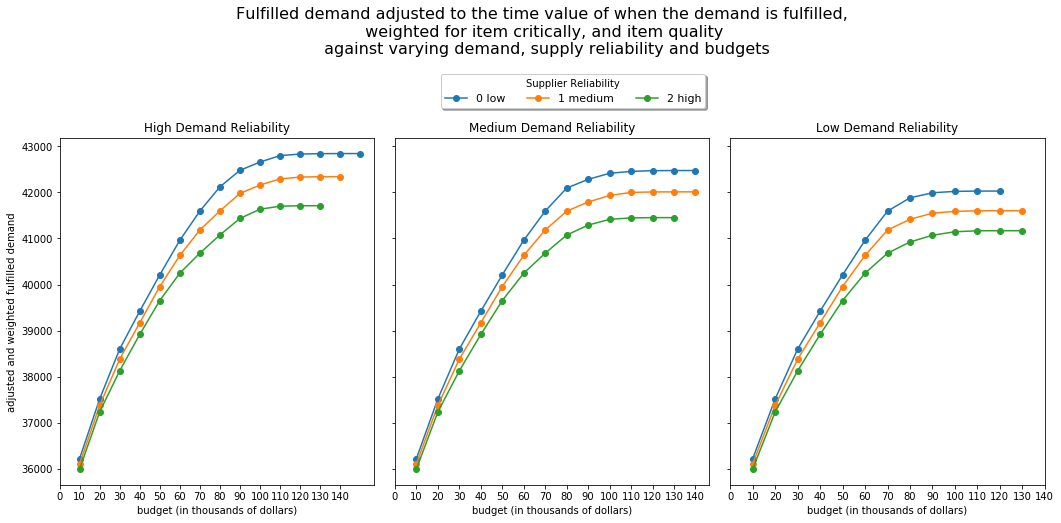

In [11]:
fig, ax = plot.subplots(nrows = 1, 
                        ncols =3, 
                        sharey = True, 
                        figsize=(18,9),
                        gridspec_kw={
                           'width_ratios': [14, 14,14],
                           'height_ratios': [1]})
fig.suptitle('Fulfilled demand adjusted to the time value of when the demand is fulfilled, \
\n weighted for item critically, and item quality \n against varying demand, supply reliability and budgets',
            size = 16)

fig.tight_layout(pad=14, w_pad=0.5, h_pad=1.0)

for d_level in ['2 high', '1 medium', '0 low']:

    if (d_level == '2 high'):
        groups = trade_off_df[trade_off_df['demand reliability']==d_level].groupby('supply reliability')
        for name, group in groups:
            ax[0].plot(group["budget"]/1000, group["obj_value"], marker="o", label=name)
            ax[0].set_title('High Demand Reliability')
            ax[0].set_xticks(np.arange(0, max(trade_off_df['budget']/1000), step=level_amount_incrememented/1000))
            ax[0].set_xlabel('budget (in thousands of dollars)')
    if (d_level == '1 medium'):
        groups = trade_off_df[trade_off_df['demand reliability']==d_level].groupby('supply reliability')
        for name, group in groups:
            ax[1].plot(group["budget"]/1000, group["obj_value"], marker="o", label=name)
            ax[1].set_title('Medium Demand Reliability')
            ax[1].set_xlabel('budget (in thousands of dollars)')
            ax[1].set_xticks(np.arange(0, max(trade_off_df['budget']/1000), step=level_amount_incrememented/1000))
    if (d_level == '0 low'):
        groups = trade_off_df[trade_off_df['demand reliability']==d_level].groupby('supply reliability')
        for name, group in groups:
            ax[2].plot(group["budget"]/1000, group["obj_value"], marker="o", label=name)
            ax[2].set_title('Low Demand Reliability')
            ax[2].set_xlabel('budget (in thousands of dollars)')
            ax[2].set_xticks(np.arange(0, max(trade_off_df['budget']/1000), step=level_amount_incrememented/1000))
            
plot.legend(loc='upper center', bbox_to_anchor=(-.5, 1.2),
          fancybox=True, shadow=True, title='Supplier Reliability', ncol=3, prop={'size': 11})

ax[0].set_ylabel('adjusted and weighted fulfilled demand')